# Exercise 2: Intermediate AD with Auto Encoders on Jets

### Goals of the exercise

- Create a basic dense auto-encoder for jets
- Create a whole event 1D "Time Distributed" Auto-encoder for event jet anomaly detection
- Create a 1D knowledge distillation model with some DeepSets properties

### Anomaly Detection With Autoencoders

**I am going to write a whole lot here about autoencoders, anomaly detection with autoencoders, and a few asides on autoencoders here. If you are already well familiar with autoencoders and the concept of anomaly detection with them, you can skip ahead a few sections**

Okay, as is pretty much an inescapable fact of life in this field, and every field right now, that neural networks are dominating the landscape, they are in all the buzzwords, and everyone wants to talk about neural networks and AI. Well, neural networks are of course used for anomaly detection too. The primary method is with auto-encoders.

I am sure that everyone has heard it by now, either before this workshop, or certainly _in_ this workshop, but an auto encoder is a neural network that is designed to reproduce it's own inputs. The thing that prevents this from being trivial, and prevents the neural network to collapsing to the identity function, is that we force it to go through a reduced information space (between the "encoder" and "decoder") called the "latent space". The idea behind this being that to be able to effectively learn to recreate it's inputs, it has to learn an efficient representation of the data it is looking at (the "encoding") or put another way, it has to learn something about the structure of the data it is looking at. The extension to anomaly detection comes when we start applying this auto-encoder to other data. If it is not from our dataset, we would expect (or hope) that this representation of the data fails, and the reconstructed data is noticeably worse. The quality of the reconstruction then becomes a metric for the anomalous-ness, the "anomaly score".

##### Aside: Out Of Set Reconstruction
This doesn't always work. Sometimes, to everyone's chagrin, you will find that the auto-encoder can work _better_ on data it has not seen. It's one of those annoying features of the expressive power of neural networks, that the patterns you hope it picks up on, are not always the pattern it does pick up on. For example, consider an auto-encoder trained to reconstruct 50 random numbers from a latent space of 20. There's not much strategy or structure to this, the single best thing you can do to be the most right is just memorize the 20 largest numbers in the set and pass those on, and guess the average for the rest. There is something to be learned while the neural network picks up on this strategy and forms the functions that approximate it in the background, but later, when given a set of 50 random numbers with higher peaks, but a lower average, you'll find it doesn't register these random spikes as anomalies because it memorizes them quite well, and it thinks the data is less anomalous than its training set!

This general problem is called "Out Of Set Reconstruction" and really deserves much more time than I can give it here. There are a number of strategies for handling it, you can change your network architecture, restrict the latent space harshly, change loss functions, try to introduce noise and drop-out, (ask ChatGPT "how do I avoid out of set reconstruction on this dataset" _but do the research on what it suggests to make sure it isn't just making things up_...) or change your strategy for what it is you are encoding. It's its own art-form. For now you should just be aware the issue exists.

### Where Was I? Right, Autoencoders

Basic auto-encoders are flat, and use dense layers like basic regression or classification neural networks. Typically they will include a few dense layers that get narrower into a latent space, then a mirror going back to the original size and shape, the first half being the "encoder" the second half the "decoder". There are a great number of variations on this concept. Some designs introduce noise and dropout into the encoder, forcing the autoencoder to learn only the most pertinent things, and get rid of noise (called a "denoising auto-encoder"). Some designs force extremely sparse latent spaces, so that only a few features at a time are used in the latent space to try and force pertinent feature construction, (to the point sometimes in these types of autoencoders that the latent space will be _larger_ than the input space, because it is so much less populated, these are called "sparse autoencoders"). A particularly useful kind makes it's latent space probabilistic, having normally distributed latent space features, being encoded as a mean and standard deviation, the resulting distribution being sampled from to decode it (the "variational autoencoders")

##### Aside: Variational Autoencoders as Generators

if you are unfamiliar with auto-encoders, especially variational ones, early generative AI stuff made heavy use of variational autoencoders. It might still, I am not super up to date on whatever models they use to make generated images. The idea was, you fed it tons upon tons of images, through a variational autoencoder, then you took only the decoding half of the model. You could feed random noise as the parameters of the distribution to get random images that looked like the images it was learning to encode, or if you studied a bit what kinds of images corresponded to what encoded bits of latent space, you could shape the noise you gave it to get images that looked like certain images you wanted.

### Let's Do Some Machine Learning with Autoencoders

For this exercise, I have a similar set of datasets to before, here: `/data/intermediate_files/`. These files do not have multiplicities, but instead a bunch of jet data in them, sorted by event.

The exact files are:
- `data/intermediate_files/ZeroBiasIntermediateData.h5`
- `data/intermediate_files/JetHTIntermediateData.h5`
- `data/intermediate_files/TTBarIntermediateData.h5`
- `data/intermediate_files/SoftQCDIntermediateData.h5`
- `data/intermediate_files/RadionIntermediateData.h5`

The physics of these files and why they were selected are in the Basic AD notebook.

The contents of the files have changed though. Now per entry there will be 8 vectors, each a jet (sorted in leading $p_{T}$ order, of 17 features each (0's if the jet does not exist).

These 17 features are (in index order):

0. Jet $p_{T}$
1. Jet $\eta$
2. Jet $phi$
3. Jet Mass
4. Number of Jet Constituents
5. Number of electrons in the jet
6. Number of muons in the jet
7. Jet charged hadron fraction
8. Jet neutral hadron fraction
9. Jet DeepCSV b+bb score (a CMS neural network classifier for b-tagging jets)
10. Jet DeepCSV c vs b score (a CMS neural network classifier for tagging c jets vs b jets)
11. Jet DeepCSV c vs udsg score (a CMS neural network classifier for tagging c jets vs light jets)
12. Jet catchment area
13. Jet DeepFlav b+bb score (a more modern neural network for b+bb tagging)
14. Jet DeepFlav c vs b score
15. Jet DeepFlav c vs light score
16. Jet DeepFlav g vs uds score

These variables were selected at random but as a pretty representative set of features that encompass jet information at CMS.

Let's load this info, and get some necessary packages

(because there is so much data here, I had to limit how much of it we load and use, these will be a bit smaller than before)



In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from time import perf_counter

from rich.console import Console

from tensorflow import keras

from sklearn.metrics import roc_curve, roc_auc_score

console = Console()

2025-06-11 09:00:45.033596: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749650445.056197 3277267 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749650445.063206 3277267 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749650445.082418 3277267 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749650445.082437 3277267 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749650445.082440 3277267 computation_placer.cc:177] computation placer alr

In [2]:
def load_data(file_path: str, limit_entries: int = -1) -> np.array:
    with h5py.File(file_path) as the_file:
        data = np.array(the_file['jet_event_data'])[:limit_entries]
    return data

zerobias_jets = load_data('data/intermediate_files/ZeroBiasIntermediateData.h5')

console.print(zerobias_jets.shape)

jetht_jets = load_data('data/intermediate_files/JetHTIntermediateData.h5')

console.print(jetht_jets.shape)

ttbar_jets = load_data('data/intermediate_files/TTBarIntermediateData.h5')

console.print(ttbar_jets.shape)

softqcd_jets = load_data('data/intermediate_files/SoftQCDIntermediateData.h5')

console.print(softqcd_jets.shape)

radion_jets = load_data('data/intermediate_files/RadionIntermediateData.h5')

console.print(radion_jets.shape)

(111928, 8, 17)

(103308, 8, 17)

(133385, 8, 17)

(204360, 8, 17)

(999, 8, 17)

These jets are laid out in a sequence in each event. This will be useful in a bit, but for now, we don't need the jets in any sequence, we just need individual jets, so we can flatten these out. Let's also get rid of any jet with $p_{T} = 0$, since these were empty jet slots that didn't exist.

In [31]:
def flatten_jets(jets:np.array)->np.array:
    return jets.reshape((-1,17))

def filter_zero_jets(jets:np.array)->np.array:
    return jets[jets[:, 0] != 0.0]

zerobias_flat_jets = filter_zero_jets(flatten_jets(zerobias_jets))
jetht_flat_jets = filter_zero_jets(flatten_jets(jetht_jets))
ttbar_flat_jets = filter_zero_jets(flatten_jets(ttbar_jets))
softqcd_flat_jets = filter_zero_jets(flatten_jets(softqcd_jets))
radion_flat_jets = filter_zero_jets(flatten_jets(radion_jets))

console.print(zerobias_flat_jets.shape)
console.print(jetht_flat_jets.shape)
console.print(ttbar_flat_jets.shape)
console.print(softqcd_flat_jets.shape)
console.print(radion_flat_jets.shape)

(96565, 17)

(666901, 17)

(962607, 17)

(326515, 17)

(6969, 17)

I am also going to split the zero bias jets up into a training, validation, and test set

In [32]:
from sklearn.model_selection import train_test_split

zerobias_train, zerobias_testval = train_test_split(zerobias_flat_jets,
                                                    test_size=0.4,
                                                    random_state = 42)
zerobias_val, zerobias_test = train_test_split(zerobias_testval,
                                               test_size=0.2/0.4,
                                               random_state = 123)

Now, let's build an auto-encoder! This is where you step in.

This is simple enough to do with Tensorflow/Keras, which is my preferred library over pytorch for simple neural network applications (pytorch is a bit more flexible admittedly).

This is where you step in. Make a neural network auto encoder model. Don't worry about compiling it or losses for right now. We'll talk about those in a second.

if you haven't built a neural network with keras before, let me know and we can go over the basics together. If you just need a refresher on what the API is like and what layers are what and go where, [this is the keras layers API](https://keras.io/api/layers/), [this is the model API](https://keras.io/api/models/) and [here is the callbacks API](https://keras.io/api/callbacks/) for later. A simple `Sequential` model will suffice here.

Some things to think about:

How big should the layers be? The only real restriction is that the latent space has to be smaller than the input one... but that's not much of a restriction. The temptation is to leave them pretty large, after all most reconstruction losses will be better that way, but we're not necessarily after the best reconstruction loss here, but instead it's ability to capture the most salient features and find outliers which is not necessarily the same thing. On the other hand, too small and you have no ability to capture much useful information. And how about intermediate encoding and decoding layers? If this were a real big project with time and resources, my recommendation would be to do some hyperparameter tuning ([keras-tuner](https://keras.io/keras_tuner/) is great for it) around some classifier like metrics on representative signal samples (that you don't train on to be clear!). Things like tuning the encoder for ROC AUC, Binary Cross Entropy, or Hinge Loss. For right now, just some guesses and starting points are good. I find a good starting place is to step down by powers of 2. In this case I would do something like a layer at 16, a final encoding layer about 8 units big, then the reverse, a layer at 16, then one at 17 units big.

Seasoned veterans of neural networks may also ask "what about regularization?". It's a good question. Neural networks are very prone to overfitting. My advice is go for it, but see how it works both ways (neural networks are like that I guess). Dropout early in the encoder is denoising technique. You could also add Gaussian Noise (I have less luck with this, but the standard wisdom says it's useful for denoising auto-encoders too). L2 regularization is also a powerful option even in something as complicated as a neural network.

The data I have given you is not normalized. You could normalize it yourself either by hand, or with a convenient sci-kit learn tool... but there are layers that will do that (or approximately that) for you. I would add `BatchNormalization`. Just remember it's there when you use the model later! _**However, put a big old pin in this topic, because I have a big aside from experience on the topic of normalizing data for anomaly detection purposes**_

In [5]:
#
# Exercise: Make a flat/dense autoencoder for jet information
#
flat_ae_model = keras.Sequential([
    #
    #encoder
    #
    keras.layers.Input(shape=zerobias_train.shape[1:]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.1), #Denoising and regularization
    #keras.layers.GaussianNoise(0.1),#Denoising and regularization
    keras.layers.Dense(8, activation='relu'),
    keras.layers.BatchNormalization(),
    #
    #decoder
    #
    keras.layers.Dense(16, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(17), #no activation function to allow for [-inf, inf]
])

W0000 00:00:1749650448.166596 3277267 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Okay. Now that we have a model, let's talk about a loss function, since the whole technique of anomaly detection hinges on using the loss function. Since this is technically a regression/reconstruction task, Mean Squared Error (MSE) is a standard, and I would recommend it to start here too. You could also use Mean Absolute Error. A rarer choise would Mean Absolute Percentage Error (providing you can use it and no output feature will be 0 or close to 0), but as part of the aside I mentioned above, I'll at least mention it as an option.

##### Aside: Anomaly Detection and Event Normalization

So while I was talking about normalization above, I mentioned `BatchNormalization`. This normalizes an event _per feature_. That is to say, that feature 1 gets normalized with respect to feature 1, so on and so forth. The slight catch to this is it means that the normalization of the entire entry technically has a floating normalization. What do I mean by that? Imagine our jet had 3 features, $p_{x}$, $p_{y}$ & $p_{z}$, if we do batch normalization, nothing prevents an individual jet with large momentum from having all 3 of those features be large individually. The features are normalized with respect to themselves, not the entry. Because the entry has "more in it" so to speak, there is more for the auto-encoder to get wrong. It isn't going to learn anything exactly so a jet with "more in it" is typically going to have a higher loss because there is more to get wrong and is going to show up as more anomalous. Similarly, you have to be careful with _feature_ normalization because features with inherently higher normalization may end up contributing more to the overall anomaly score than something else.

This _may_ not be an issue. In this example, it is not unreasonable that we say "yeah, high $p_{T}$ jets should be more anomalous", but you should be aware of this effect. If you don't want to consider the overall normalization of an object/event/whatever in your anomaly detection, you need to find ways to mitigate this. One is using `LayerNormalization` cleverly, normalizing every object/event/whatever such that the event always has an overall normalization of 0 or close to 0. Another is using scale invariant losses like Mean Absolure Percentage Error. To avoid the feature issue, you can normalize features before considering anything, and only do anomaly scores and losses with respect to the already normalized features.


### Back to the show

Let's compile this, and use Mean Absolute Error as a metric (use Adam or Nadam as an optimizer)

In [6]:
#
# Exercise: compile the neural network model
#
flat_ae_model.compile(
    loss='mse',
    optimizer='adam',
    metrics=['mae']
)

Now, let's get to training! I love this part.

You can train for as long as you like (a neural network expert I used to know always told me to just train models for as long as you have and as much CPU power as you have until you get bored or need to use it, so long as you save the best model). A simple choice would be to just do 10-20 epochs or something. Myself, I would probably set it to something large like 200 epochs, but use a callback (`EarlyStopping` with it's `restore_best_weights` option to just train until it plateaus or starts overfitting, and then automatically get the best one back without having to save anything to disk right now)

If you're new to auto-encoders, the `X` and `Y` in the `fit` call are the same thing here! Remember to use the validation data too!

In [7]:
#
# Exercise: fit your flat jet autoencoder
#
flat_ae_model.fit(
    x=zerobias_train,
    y=zerobias_train,
    epochs=200,
    #steps_per_epoch=10000,
    validation_data=(zerobias_val, zerobias_val),
    callbacks=[
        keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
    ]
)

Epoch 1/200
1811/1811 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 19.5488 - mae: 1.7040 - val_loss: 0.2880 - val_mae: 0.2612
Epoch 2/200
1811/1811 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.0346 - mae: 0.3724 - val_loss: 0.2488 - val_mae: 0.2240
Epoch 3/200
1811/1811 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.9519 - mae: 0.3437 - val_loss: 0.1527 - val_mae: 0.1855
Epoch 4/200
1811/1811 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.7196 - mae: 0.3268 - val_loss: 0.1872 - val_mae: 0.1793
Epoch 5/200
1811/1811 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.7083 - mae: 0.3216 - val_loss: 0.1687 - val_mae: 0.1721
Epoch 6/200
1811/1811 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.6496 - mae: 0.3145 - val_loss: 0.1695 - val_mae: 0.1685
Epoch 7/200
1811/1811 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.6209 - mae: 0.3112 - val_loss: 0.2075 - val_mae: 0.1811
Epoch 8/200
1811/1811 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.7170 - mae: 0.3165 - val_loss: 0.1222 - val_mae: 0.1576
Epoch 9/200
1811/1811 ━━━━━━━━━

Alright. Let's see how we did.

First thing's first, you should evaluate this on the zerobias test set to make sure the performace is what we think it is.

In [8]:
#
# Exercise: Evaluate the model using `evaluate`
#

flat_ae_model.evaluate(x=zerobias_test, y=zerobias_test)

604/604 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step - loss: 0.0689 - mae: 0.1413


[0.07331208139657974, 0.14195191860198975]

If you've set up a model like me, I get an MSE loss of about $\approx 0.07$. That may depend on the specifics of your network though.

There's a lot of things I am not going to have time to get into. A fun thing to do would be to go through and look at jet reconstructions and see what things this auto-encoder gets wrong and where, and see if it gets things wrong in tandem with each other and so on, so in classic physics style I guess I'll leave that problem for the student. Let's just quickly take a look at how it performs on one jet though



In [9]:
console.print(flat_ae_model.predict(zerobias_val[0:1]))
console.print(zerobias_val[0:1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


[[ 1.5833956e+01  2.9514842e+00  8.6934417e-01  3.2594564e+00
   9.0056543e+00 -4.9073063e-03 -2.2919332e-03  1.7175683e-01
   6.3417590e-01 -8.9508808e-01 -8.8015246e-01 -8.9921582e-01
   5.2417207e-01  6.2035710e-02  5.6922293e-01  9.4432816e-02
   6.6298944e-01]]

[[15.2109375   2.93115234  0.82128906  2.82421875  9.          0.
   0.          0.          0.30859375 -1.         -1.         -1.
   0.51855469  0.08178711  0.51367188  0.09411621  0.63916016]]

What we should do is start using this for anomaly detection. Which means that we need anomaly scores, which are our losses. I'll give you this utility for making anomaly scores, asuming you are using Mean Squared Error as your loss

In [10]:
def make_anomaly_scores(model, input_dataset: np.array) -> np.array:
    predictions = np.array(model.predict(input_dataset))
    mse = np.mean((predictions-input_dataset)**2, axis=1)
    return mse

In [33]:
#
# Exercise: get anomaly scores for all distributions
#

zerobias_anomaly_scores = make_anomaly_scores(flat_ae_model, zerobias_test)
jetht_anomaly_scores = make_anomaly_scores(flat_ae_model, jetht_flat_jets)
ttbar_anomaly_scores = make_anomaly_scores(flat_ae_model, ttbar_flat_jets)
softqcd_anomaly_scores = make_anomaly_scores(flat_ae_model, softqcd_flat_jets)
radion_anomaly_scores = make_anomaly_scores(flat_ae_model, radion_flat_jets)

604/604 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step
20841/20841 ━━━━━━━━━━━━━━━━━━━━ 12s 574us/step
30082/30082 ━━━━━━━━━━━━━━━━━━━━ 17s 558us/step
10204/10204 ━━━━━━━━━━━━━━━━━━━━ 6s 567us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 612us/step


As before, a really good thing to do is check out anomaly scores or anomalousness against certain features. Get some scatter plots on the zero bias test set between anomaly score, and jet $p_{T}$, $\eta$, number of constituents, and the DeepFlav b tag score. Also, calcualte the (Pearson) correlation coefficients. Let's see what "anomalous" is to this autoencoder

In [34]:
console.print(np.mean(zerobias_anomaly_scores))
console.print(np.std(zerobias_anomaly_scores))
console.print(np.mean(jetht_anomaly_scores))
console.print(np.std(jetht_anomaly_scores))

0.07331207570759683

0.8910676137289776

130.07393761574082

413.3751857863819

In [38]:
#
# Exercise: Create pearson correlation coefficients of znomaly scores
#

for feature in range(17):
    correlation_coeff = np.corrcoef(zerobias_anomaly_scores, zerobias_test[:, feature])[0][1] #returns a matrix
    console.print(f'Anomaly score correlation to feature {feature}: {correlation_coeff:.4g}')

Anomaly score correlation to feature 0: 0.3582

Anomaly score correlation to feature 1: 0.002485

Anomaly score correlation to feature 2: 0.007009

Anomaly score correlation to feature 3: 0.189

Anomaly score correlation to feature 4: 0.04922

Anomaly score correlation to feature 5: 0.03752

Anomaly score correlation to feature 6: 0.01811

Anomaly score correlation to feature 7: 0.02043

Anomaly score correlation to feature 8: -0.02363

Anomaly score correlation to feature 9: 0.02646

Anomaly score correlation to feature 10: 0.01717

Anomaly score correlation to feature 11: 0.02678

Anomaly score correlation to feature 12: -0.00906

Anomaly score correlation to feature 13: 0.06569

Anomaly score correlation to feature 14: -0.002327

Anomaly score correlation to feature 15: 0.055

Anomaly score correlation to feature 16: -0.01881

I find in my model that the anomaly score is most correlated to the jet's $p_{T}$, the jet's mass, and the jet's b-tagging score (followed by charm versus light tagging and number of constituents). Not unreasonable (but note that both $p_{T}$ and $m$ are two of the higher overall normalization features...). However, we should take a direct look at some of them, because correlation coefficient doesn't catch non-linear relationships.

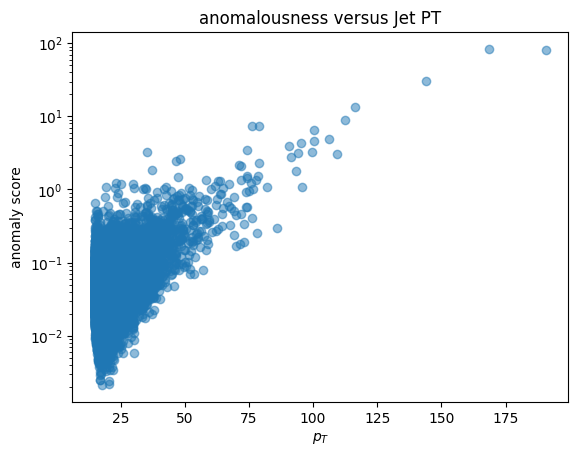

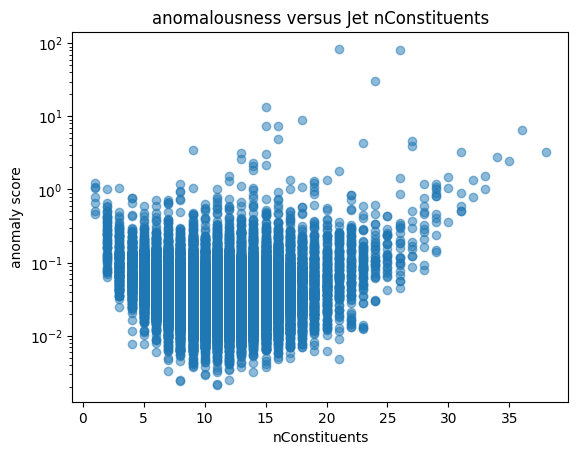

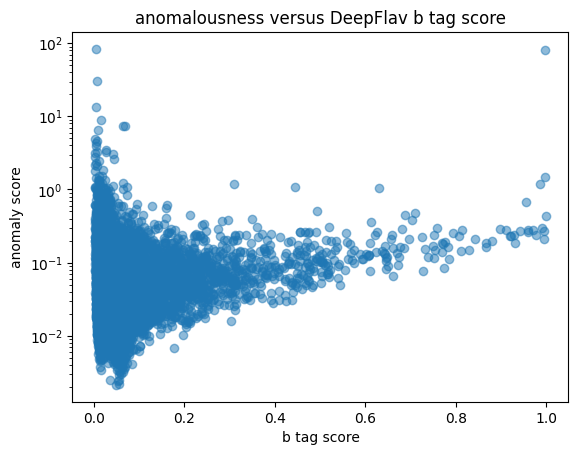

<Figure size 640x480 with 0 Axes>

In [37]:
#
# Exercise: Look at zerobias anomaly scores versus certain features in scatter plots
#

plt.scatter(
    zerobias_test[:, 0],
    zerobias_anomaly_scores,
    alpha=0.5
)

plt.ylabel('anomaly score')
plt.xlabel(r'$p_{T}$')
plt.title('anomalousness versus Jet PT')
plt.yscale('log')
plt.show()
plt.clf()

plt.scatter(
    zerobias_test[:, 4],
    zerobias_anomaly_scores,
    alpha=0.5
)

plt.ylabel('anomaly score')
plt.xlabel(r'nConstituents')
plt.title('anomalousness versus Jet nConstituents')
plt.yscale('log')
plt.show()
plt.clf()

plt.scatter(
    zerobias_test[:, 13],
    zerobias_anomaly_scores,
    alpha=0.5
)

plt.ylabel('anomaly score')
plt.xlabel(r'b tag score')
plt.title('anomalousness versus DeepFlav b tag score')
plt.yscale('log')
plt.show()
plt.clf()

With my model, I find that the anomaly score is higher for jets with **too low or too high nConstituents**

Alright, like we did in the basic exercises, let's check whether jets not from Zero Bias (i.e. straight from the CMS beam with no preselection) look more anomalous to us. Let's make score plots per sample, and then make a ROC curve comparing the JetHT dataset, $t\bar{t}$ and radion to Zero bias, a ROC curve comparing $t\bar{t}$ and radion to JetHT, and a ROC curve comparing $t\bar{t}$ and radion to soft qcd

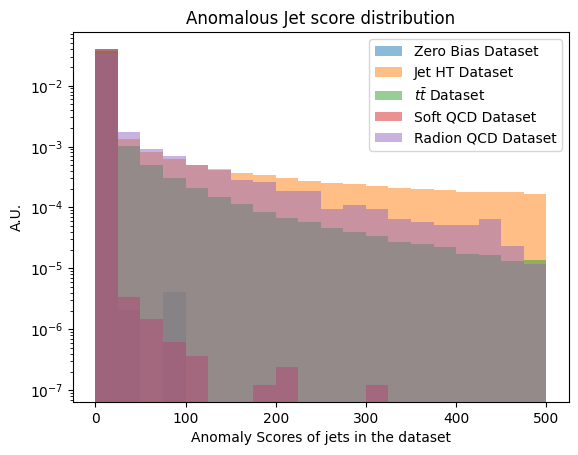

<Figure size 640x480 with 0 Axes>

In [15]:
#
# Exercise: Make score plots for each sample
#

plt.hist(
    zerobias_anomaly_scores,
    bins=20,
    range=(0.0, 500.0),
    alpha=0.5,
    histtype='stepfilled',
    density=True,
    label='Zero Bias Dataset'
)

plt.hist(
    jetht_anomaly_scores,
    bins=20,
    range=(0.0, 500.0),
    alpha=0.5,
    histtype='stepfilled',
    density=True,
    label = 'Jet HT Dataset',
)

plt.hist(
    ttbar_anomaly_scores,
    bins=20,
    range=(0.0, 500.0),
    alpha=0.5,
    histtype='stepfilled',
    density=True,
    label =  r'$t\bar{t}$'+' Dataset',
)

plt.hist(
    softqcd_anomaly_scores,
    bins=20,
    range=(0.0, 500.0),
    alpha=0.5,
    histtype='stepfilled',
    density=True,
    label =  'Soft QCD Dataset',
)

plt.hist(
    radion_anomaly_scores,
    bins=20,
    range=(0.0, 500.0),
    alpha=0.5,
    histtype='stepfilled',
    density=True,
    label = 'Radion QCD Dataset',
)

plt.xlabel("Anomaly Scores of jets in the dataset")
plt.ylabel("A.U.")
plt.title("Anomalous Jet score distribution")

plt.yscale('log')

plt.legend()

plt.show()
plt.clf()

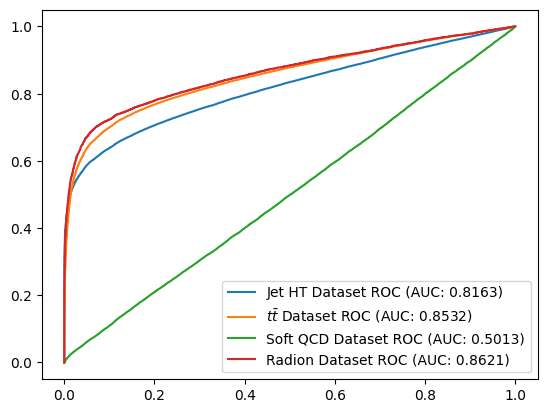

In [16]:
#
# Exercise: Create ROC plots for the jet distributions for different datasets versus zero bias
#

def make_roc(background_scores, signal_scores, legend_label) -> None:
    y_true = np.append(
        np.ones(len(signal_scores)),
        np.zeros(len(background_scores)),
        axis=0
    )

    y_pred = np.append(
        signal_scores,
        background_scores,
        axis=0,
    )

    fpr, tpr, _ = roc_curve(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)

    plt.plot(
        fpr,
        tpr,
        label=f'{legend_label} ROC (AUC: {auc:.4})'
    )

make_roc(zerobias_anomaly_scores, jetht_anomaly_scores, 'Jet HT Dataset')
make_roc(zerobias_anomaly_scores, ttbar_anomaly_scores, r'$t\bar{t}$ Dataset')
make_roc(zerobias_anomaly_scores, softqcd_anomaly_scores, 'Soft QCD Dataset')
make_roc(zerobias_anomaly_scores, radion_anomaly_scores, 'Radion Dataset')
plt.legend()

We find the interesting datasets' jets do have some good anomalousness to this model, but not _terrific_ (again, we do well on a wide set of things, but are not super performers on any one thing, that's the nature of these minimally biased techniques). In my ROCs I found that it was basically impossible to tell the difference between soft QCD and zero bias jets, and the best performance/most anomalous jets were for $t\bar{t}$. 

There's more we could do here, but we need to move on.

One of the criticisms of this model, is that it is pretty isolated. It considers one jet a time. The anomalous-ness is per jet not per event and that may help us in finding interesting physics. This is why these jets are stored in sets. We are going to make a 1D auto-encoder.

Now most 1D auto-encoders are 1D convolutional auto-encoders, and most 1D convolutional models and indeed most 1D data in machine-learning assumes the single dimension is time. You will often hear it referred to as the time axis or the time dimension. It doesn't need to be, and it won't be in our case, but I wanted to bring it up to be clear.

But because we're not doing anything in time, Convolutional auto-encoders don't make sense in our case. The relative adjacency of the jets in the set really doesn't have much to do with each other (sure it has a bit, being $p_{T}$ ordered, but not so much as to justify convolutional treatment, and certainly not any recurrent treatment). However, a common thing in 1D neural networks are what are called "time distributed layers". In effect, a time distributed layer treats each step as a single flat set of data, and we train the same flat layer for each "time" step. We can then train an entire auto-encoder on all these jets at once, and get an _overall_ view of how anomalous we think the whole event jet setup was!

Setting that up is your next exercise. [This is the time distributed layer documentation](https://keras.io/api/layers/recurrent_layers/time_distributed). Split up the data, make the model, compile it, and train it.

(note, because tensorflow/keras needs to know the input shape of every event, we can't get rid of the "empty" jets here)

In [17]:
#
# Exercise: Using time distributed dense layers, make a 1D auto encoder
#

zerobias_train, zerobias_testval = train_test_split(zerobias_jets,
                                                    test_size=0.4,
                                                    random_state = 42)
zerobias_val, zerobias_test = train_test_split(zerobias_testval,
                                               test_size=0.2/0.4,
                                               random_state = 123)

console.print(zerobias_train.shape)

ae_model = keras.Sequential([
    #
    # encoder
    #
    keras.layers.Input(shape=zerobias_train.shape[1:]),
    keras.layers.BatchNormalization(),
    keras.layers.TimeDistributed(
        keras.layers.Dense(16, activation='relu')
    ),
    keras.layers.BatchNormalization(),
    keras.layers.TimeDistributed(
        keras.layers.Dropout(0.1)
    ),
    keras.layers.TimeDistributed(
        keras.layers.Dense(8, activation='relu')
    ),
    keras.layers.BatchNormalization(),
    #
    # decoder
    #
    keras.layers.TimeDistributed(
        keras.layers.Dense(16, activation='relu')
    ),
    keras.layers.BatchNormalization(),
    keras.layers.TimeDistributed(
        keras.layers.Dense(17), #no activation function to allow for [-inf, inf]
    )
])

ae_model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae'],
)

ae_model.fit(
    x=zerobias_train,
    y=zerobias_train,
    epochs=200,
    #steps_per_epoch=10000,
    validation_data=(zerobias_val, zerobias_val),
    callbacks=[
        keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
    ]
)

(67156, 8, 17)

Epoch 1/200
2099/2099 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 0.8960 - mae: 0.1998 - val_loss: 0.1091 - val_mae: 0.1543
Epoch 2/200
2099/2099 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.1339 - mae: 0.0945 - val_loss: 0.1266 - val_mae: 0.2010
Epoch 3/200
2099/2099 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.1229 - mae: 0.0918 - val_loss: 0.3366 - val_mae: 0.1557
Epoch 4/200
2099/2099 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.1112 - mae: 0.0921 - val_loss: 0.1985 - val_mae: 0.1650
Epoch 5/200
2099/2099 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0934 - mae: 0.0881 - val_loss: 0.0249 - val_mae: 0.0740
Epoch 6/200
2099/2099 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0909 - mae: 0.0867 - val_loss: 0.0684 - val_mae: 0.1191
Epoch 7/200
2099/2099 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0839 - mae: 0.0851 - val_loss: 0.0313 - val_mae: 0.0814
Epoch 8/200
2099/2099 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0862 - mae: 0.0843 - val_loss: 0.0259 - val_mae: 0.0783
Epoch 9/200
2099/2099 ━━

### Knowledge Distillation

It's great that we have that big model for doing event wide stuff, but calculating the loss each time is time consuming and clunky. What's more, the reconstructed jet or event we make doesn't serve much purpose, except to see how wrong we got it. A common technique, especially in resource constrained environments like an FPGA, is to build a model that "skips straight to the answer". That is, you train a model that predicts from the inputs, what the loss of the auto-encoder would be. This technique is called "knowledge distillation". The basic idea is that you train a big anomaly detection auto-encoder, then have it make a bunch of losses on a training set. From that set of losses, and the inputs that made them, you have a new model start from those inputs, and predict the loss.

We're going to do that with our big, event based network. It would be good also for this network to be order invariant. The original auto-encoder and the data is sorted via $p_{T}$ but it would be good for the anomaly score to not depend on that. To achieve that, we're going to use more `TimeDistributed` layers, which are order invariant, and we're going to be clever about picking our 1D $\rightarrow$ flat function/layer to be one that is order invariant (`GlobalMaxPooling1D` or `GlobalAveragePooling1D`). This is adjacent to a technique for processing set based data called DeepSets. 

Strictly, to avoid overfitting issues, we should have split the dataset 4 ways at the start, one auto-encoder training set, one knowledge distillation training set, a validation set, and a testing set. We're going to just re-use the training set, but don't do that for real things. Let's make a network and do a first training:

In [25]:
#
# Exercise: make the anomaly scores for the training, test and validation set, and the signal distributions too
#

def make_event_anomaly_scores(model, input_dataset):
    predictions = np.array(model.predict(input_dataset)).reshape(input_dataset.shape)
    mse = np.mean((predictions-input_dataset)**2, axis=(1,2))
    return mse

zerobias_score_train = make_event_anomaly_scores(ae_model, zerobias_train)
zerobias_score_val = make_event_anomaly_scores(ae_model, zerobias_val)
zerobias_score_test = make_event_anomaly_scores(ae_model, zerobias_test)

jetht_score = make_event_anomaly_scores(ae_model, jetht_jets)
ttbar_score = make_event_anomaly_scores(ae_model, ttbar_jets)
softqcd_score = make_event_anomaly_scores(ae_model, softqcd_jets)
radion_score = make_event_anomaly_scores(ae_model, radion_jets)

2099/2099 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
700/700 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
700/700 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
3229/3229 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
4169/4169 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
6387/6387 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [23]:
#
# Make a knowledge distillation model, using time distributed layers and GlobalMaxPooling1D, and train it
#

simple_model = keras.Sequential([
    keras.layers.Input(shape=zerobias_train.shape[1:]),
    keras.layers.BatchNormalization(),
    keras.layers.TimeDistributed(
        keras.layers.Dense(16, activation='relu')
    ),
    keras.layers.BatchNormalization(),
    keras.layers.TimeDistributed(
        keras.layers.Dropout(0.1)
    ),
    keras.layers.TimeDistributed(
        keras.layers.Dense(8, activation='relu')
    ),
    keras.layers.BatchNormalization(),
    keras.layers.GlobalMaxPooling1D(),
    keras.layers.Dense(4, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(1),
])

simple_model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

simple_model.fit(
    x=zerobias_train,
    y=zerobias_score_train,
    epochs=200,
    #steps_per_epoch=10000,
    validation_data=(zerobias_val, zerobias_score_val),
    callbacks=[
        keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
    ]
)

Epoch 1/200
2099/2099 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.4664 - mae: 0.3400 - val_loss: 0.0855 - val_mae: 0.1271
Epoch 2/200
2099/2099 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.1450 - mae: 0.0546 - val_loss: 0.0491 - val_mae: 0.0571
Epoch 3/200
2099/2099 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.0716 - mae: 0.0355 - val_loss: 0.0380 - val_mae: 0.0418
Epoch 4/200
2099/2099 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0592 - mae: 0.0251 - val_loss: 0.0364 - val_mae: 0.0312
Epoch 5/200
2099/2099 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.1918 - mae: 0.0350 - val_loss: 0.0368 - val_mae: 0.0586
Epoch 6/200
2099/2099 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0972 - mae: 0.0301 - val_loss: 0.0339 - val_mae: 0.0217
Epoch 7/200
2099/2099 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.0751 - mae: 0.0224 - val_loss: 0.0331 - val_mae: 0.0495
Epoch 8/200
2099/2099 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0712 - mae: 0.0264 - val_loss: 0.0323 - val_mae: 0.0191
Epoch 9/200
2099/2099 ━━━━━━━━━

Let's be sure to evaluate it too...

In [24]:
#
# Exercise: evaluate the knowledge distillation model on the test set
#
simple_model.evaluate(zerobias_test, zerobias_score_test)

700/700 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.9333 - mae: 0.0311


[1.6308910846710205, 0.034421246498823166]

If your model is anything like mine, you might see a suprisingly high error predicting the anomaly score here, compared to what the validation loss might make you think.

One of the things we should be sure of is that the model performance is relatively _even_. Because anomalies are rarer by definition, they are underrepresented in our training data, and thus the model is likelier to be less accurate for those... precisely where we want the _most_ accuracy. Make some plots showing the knowledge distillation model error versus true anomaly score on zero bias!

700/700 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


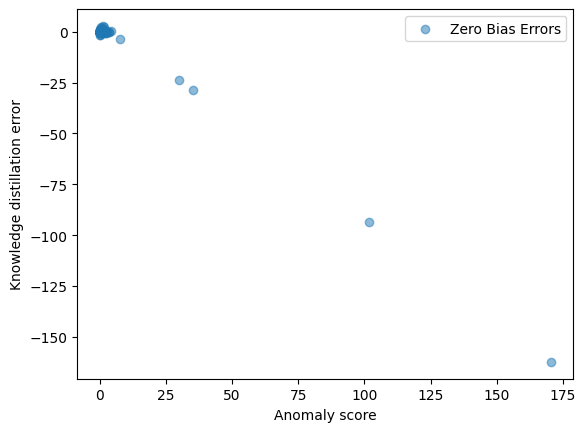

<Figure size 640x480 with 0 Axes>

In [28]:
#
# Exercise: make some scatter plots of the error in the knowledge distillation model prediction versus true anomaly score
#

zerobias_prediction = np.array(simple_model.predict(zerobias_test)).reshape(zerobias_score_test.shape)
zerobias_error = (zerobias_prediction-zerobias_score_test)
#ttbar_prediction = np.array(simple_model.predict(ttbar_jets)).reshape(ttbar_score.shape)
#ttbar_error = (ttbar_prediction - ttbar_score)

plt.scatter(
    zerobias_score_test,
    zerobias_error,
    alpha=0.5,
    label='Zero Bias Errors'
)

#plt.scatter(
#    ttbar_score,
#    ttbar_error,
#    alpha=0.5,
#    label= r'$t\bar{t}$' + ' Errors'
#)

plt.ylabel('Knowledge distillation error')
plt.xlabel('Anomaly score')

plt.legend()
plt.show()
plt.clf()

There are a few ways around this. The first is to cleverly pick the events you use for training, to assure that there is an even representation of anomaly scores (and other secondary variables you may want even performance in). The other is to provide sample weights for the training data to ensure that there is roughly even weighting for different anomaly scores. We won't have time to get into that here, but be aware of those as options.

Now, as we have done before, let's check out the model performance on samples of interest! Make some ROCs!

4169/4169 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3229/3229 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
6387/6387 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


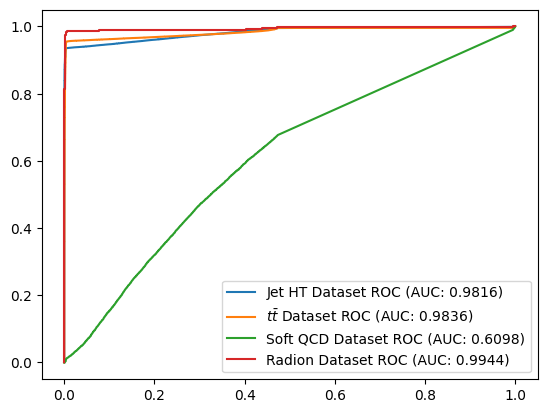

In [30]:
#
# Exercise: make some ROCs for the knowledge distillation model
#
ttbar_prediction = np.array(simple_model.predict(ttbar_jets)).reshape(ttbar_score.shape)
jetht_prediction = np.array(simple_model.predict(jetht_jets)).reshape(jetht_score.shape)
softqcd_prediction = np.array(simple_model.predict(softqcd_jets)).reshape(softqcd_score.shape)
radion_prediction = np.array(simple_model.predict(radion_jets)).reshape(radion_score.shape)

make_roc(zerobias_prediction, jetht_prediction, 'Jet HT Dataset')
make_roc(zerobias_prediction, ttbar_prediction, r'$t\bar{t}$ Dataset')
make_roc(zerobias_prediction, softqcd_prediction, 'Soft QCD Dataset')
make_roc(zerobias_prediction, radion_prediction, 'Radion Dataset')

plt.legend()

In spite of the possibly poor accuracy to anomalies, you will likely find that it does a pretty good job in the ROC plots and in the ROC AUC's (potentially even outperforming the autoencoder it was based on! This can happen due to some simple patterns it picks up, like "higher energy = more anomalous in general" where the auto-encoder may learn to fit some of those too well, the knowledge distillation model is simpler). The knowledge distillation can be a bit disappointing in terms of overall accuracy to the autoencoder, but it can maintain the _order_ of scores (signals higher, backgrounds lower), which is what matters in ROCs (and setting thresholds for use and things like that).

Another "exercise for the reader" we could do here is retrain the model on the dedicated Jet HT set and see how that model compares.

### Wrap-up

These are some basic (and slightly more advanced) ideas in anomaly detection for objects and events. Let's get into some advanced ideas for anomaly detection with whole events, and other types of neural networks in the next exercise.